C:\Users\BiXY\anaconda3\envs\mmcv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['0.Rice', '1.Drink', '2.Green Leaf Vegetables', '3.Meat', '4.Noodles']
[tensor([[[[-0.6549, -0.6314, -0.6078,  ..., -0.7333, -0.7255, -0.7098],
          [-0.6941, -0.6706, -0.6471,  ..., -0.7412, -0.7333, -0.7176],
          [-0.7412, -0.7098, -0.6941,  ..., -0.7412, -0.7412, -0.7333],
          ...,
          [-0.7647, -0.7725, -0.7961,  ..., -0.6235, -0.6471, -0.6706],
          [-0.7569, -0.7804, -0.7961,  ..., -0.6314, -0.6549, -0.6863],
          [-0.7647, -0.7882, -0.8039,  ..., -0.6471, -0.6627, -0.6863]],

         [[-0.0196,  0.0039,  0.0118,  ..., -0.6471, -0.6392, -0.6235],
          [-0.0980, -0.0824, -0.0667,  ..., -0.6549, -0.6471, -0.6314],
          [-0.1765, -0.1765, -0.1686,  ..., -0.6549, -0.6549, -0.6471],
          ...,
          [-0.5451, -0.5451, -0.5294,  ..., -0.4431, -0.4510, -0.4667],
          [-0.5373, -0.5451, -0.5216,  ..., -0.4824, -0.4902, -0.4902],
          [-0.5373, -0.5373, -0.5137,  ..., -0.4980, -0.5059, -0.5216]],

         [[-0.8902, -0.8824, 

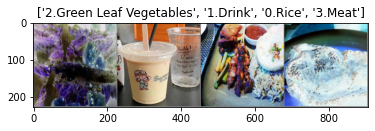

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import copy       # helps to make copies instead of references
import time
from tqdm.auto import tqdm

random.seed(1)
food_label = {"0.Rice": 0, "1.Drink": 1, "2.Green Leaf Vegetables": 2, "3.Meat": 3, "4.Noodles": 4}


# class Food_Dataset(Dataset):
#     def __init__(self, data_dir, transform=None):
#         """
#         Datasets of Food classification
#         :param data_dir: str, path of food datasets
#         :param transform: torch.transform，data preprocessing
#         """
#         self.label_name = {"0.Rice": 0, "1.Drink": 1, "2.Green Leaf Vegetables": 2, "3.Meat": 3, "4.Noodles": 4}
#         self.data_info = self.get_img_info(data_dir)  # data_info stores the path and the label of every photo,and read samples by index in Dataloader
#         self.transform = transform                     
#
#     def __getitem__(self, index):
#         path_img, label = self.data_info[index]
#         img = Image.open(path_img).convert('RGB')     # 0~255
#
#         if self.transform is not None:
#             img = self.transform(img)   # perform transformation here,to tensor and so on
#
#         return img, label
#
#     def __len__(self):
#         return len(self.data_info)
#
#     @staticmethod
#     def get_img_info(data_dir):
#         data_info = list()
#         for root, dirs, _ in os.walk(data_dir):
#             # visit each class
#             for sub_dir in dirs:
#                 img_names = os.listdir(os.path.join(root, sub_dir))
#                 img_names = list(filter(lambda x: x.endswith('.jpg'), img_names))
#
#                 # visit each photo
#                 for i in range(len(img_names)):
#                     img_name = img_names[i]
#                     path_img = os.path.join(root, sub_dir, img_name)
#                     label = food_label[sub_dir]
#                     data_info.append((path_img, int(label)))
#
#         return data_info
#
# food_dataset = Food_Dataset(r'C:\Users\BiXY\OneDrive - 厦门大学(马来西亚分校)\AIT202\Project\Food_Dataset')

# transform setting
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

data_transform = {
    'train': transforms.Compose([
        transforms.AutoAugment(),
        transforms.RandomResizedCrop(224), # 224 x 224 shrink the picture
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Normalize to [0.0,1.0]
        transforms.Normalize(mean, std) # transform every number in the tensor to be in the range of [-1,1]
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224), # crop it from the middle
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224), # crop it from the middle
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}


batch_size = 4
data_dir = r'C:\Users\BiXY\OneDrive - 厦门大学(马来西亚分校)\AIT202\Project\Food_Dataset_split'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(class_names)

def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    img = std*img + mean
    plt.imshow(img)
    plt.title(title)
    plt.show()

inputs, classes = next(iter(dataloaders['train']))
print(next(iter(dataloaders['train'])))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [2]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # channel = 3, 5x5, filter num: 6 stride = 1
        self.pool = nn.MaxPool2d(2, 2)  # size, stride=2(shrunk it half)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        # n, 3, 32, 32
        x = self.conv1(x)  # n, 6, 28, 28
        x = F.relu(x)
        x = self.pool(x)  # n, 6, 14, 14
        x = self.conv2(x)  # n, 16, 10, 10
        x = F.relu(x)
        x = self.pool(x)  # n, 16, 5, 5
        x = x.view(-1, 44944)  # n, 400, -1 is batches
        x = self.fc1(x)  # n, 120
        x = F.relu(x)
        x = self.fc2(x)  # n, 84
        x = F.relu(x)
        x = self.fc3(x)  # n, 10
        return x

In [3]:
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=5):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(25088 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

In [4]:
from collections import OrderedDict

#regard one convolutional layer as a basic conv
class BasicConv2d_moveBN(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride=1, padding=0):
        super(BasicConv2d_moveBN, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size,
                      stride=stride, padding=padding, bias=False)

    def forward(self, x):
        x = self.conv(x)
        return x
    
# one bottleneck module
class Bottleneck_moveBN(nn.Module):
    def __init__(self, in_channel, mid_channel, out_channel, stride=1):
        super(Bottleneck_moveBN, self).__init__()

        self.judge = in_channel == out_channel

        self.bottleneck = nn.Sequential(OrderedDict([
            ('Conv1',BasicConv2d_moveBN(in_channel, mid_channel, 1)),
            ('Relu1',nn.ReLU(True)),
            ('Conv2',BasicConv2d_moveBN(mid_channel, mid_channel, 3, padding=1, stride=stride)),
            ('Relu2',nn.ReLU(True)),
            ('Conv3',BasicConv2d_moveBN(mid_channel, out_channel, 1)),]
        ))
        self.relu = nn.ReLU(True)
        # here we use linear projection to match dimensions by an 1x1 convolutional layer
        if in_channel != out_channel:
            self.projection = BasicConv2d_moveBN(
                in_channel, out_channel, 1, stride=stride)

    def forward(self, x):
        out = self.bottleneck(x)
        # perform projection on the residual by an 1x1 convolutional layer if input channel doesn't equal output channel
        if not self.judge:
            self.shortcut = self.projection(x)
            # out += projection of residual
            out += self.shortcut
        # otherwise, add them together directly
        else:
            out += x

        out = self.relu(out)

        return out

# Modified Resnet50:
class ResNet_50_modified(nn.Module):
    def __init__(self, class_num):
        super(ResNet_50_modified, self).__init__()
        self.conv = BasicConv2d_moveBN(3, 64, 7, stride=2, padding=3)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        # convolutional block 1
        self.block1 = nn.Sequential(
            Bottleneck_moveBN(64, 64, 256),
            Bottleneck_moveBN(256, 64, 256),
            Bottleneck_moveBN(256, 64, 256),
        )
        # convolutional block 2
        self.block2 = nn.Sequential(
            Bottleneck_moveBN(256, 128, 512, stride=2),
            Bottleneck_moveBN(512, 128, 512),
            Bottleneck_moveBN(512, 128, 512),
            Bottleneck_moveBN(512, 128, 512),
        )
        self.avgpool = nn.AvgPool2d(4)
        self.classifier = nn.Linear(25088, class_num)

    def forward(self, x):
        x = self.conv(x)
        x = self.maxpool(x)
        x = self.block1(x)
        x = self.block2(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        out = self.classifier(x)

        return out

In [5]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
# model = ResNet_50(5).to(device)
# model = ResNet18_original().to(device)
# model = ResNet34_original().to(device)
# model = ResNet34_move_BN().to(device)
# model = ResNet18_move_BN().to(device)
model = ResNet_50_modified(5).to(device)

# 1. optimizer = Adam, Learning rate = 0.01, weight_decay=1e-4

In [6]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

In [7]:
# The number of training epochs.
n_epochs = 20
t_loss1 = []
t_acc1 = []
v_loss1 = []
v_acc1 = []
for epoch in range(n_epochs):
# Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    
    # Iterate the training set by batches.
    for batch in tqdm(dataloaders['train']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    t_loss1.append(train_loss)
    t_acc1.append(train_acc)
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    # Iterate the validation set by batches.
    for batch in tqdm(dataloaders['valid']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    v_loss1.append(valid_loss)
    v_acc1.append(valid_acc)
    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:50<00:00,  3.75it/s]


[ Train | 001/020 ] loss = 51.72199, acc = 0.15957


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.22it/s]


[ Valid | 001/020 ] loss = 1.60957, acc = 0.20500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.11it/s]


[ Train | 002/020 ] loss = 80.67159, acc = 0.17686


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.56it/s]


[ Valid | 002/020 ] loss = 1.60968, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.21it/s]


[ Train | 003/020 ] loss = 1.61291, acc = 0.19016


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.46it/s]


[ Valid | 003/020 ] loss = 1.61015, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.98it/s]


[ Train | 004/020 ] loss = 27.51712, acc = 0.19814


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.25it/s]


[ Valid | 004/020 ] loss = 1.61017, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.97it/s]


[ Train | 005/020 ] loss = 1.61288, acc = 0.17553


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.70it/s]


[ Valid | 005/020 ] loss = 1.60993, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.14it/s]


[ Train | 006/020 ] loss = 1.61302, acc = 0.17553


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.65it/s]


[ Valid | 006/020 ] loss = 1.60981, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.05it/s]


[ Train | 007/020 ] loss = 1.61324, acc = 0.19548


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.33it/s]


[ Valid | 007/020 ] loss = 1.61025, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.15it/s]


[ Train | 008/020 ] loss = 1.61290, acc = 0.18218


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.75it/s]


[ Valid | 008/020 ] loss = 1.60975, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.07it/s]


[ Train | 009/020 ] loss = 2579954.23047, acc = 0.17553


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.55it/s]


[ Valid | 009/020 ] loss = 1.60951, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.18it/s]


[ Train | 010/020 ] loss = 1.61322, acc = 0.17420


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.42it/s]


[ Valid | 010/020 ] loss = 1.60956, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.19it/s]


[ Train | 011/020 ] loss = 1.61372, acc = 0.20213


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.20it/s]


[ Valid | 011/020 ] loss = 1.60997, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.06it/s]


[ Train | 012/020 ] loss = 1.61255, acc = 0.17952


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.57it/s]


[ Valid | 012/020 ] loss = 1.60979, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:43<00:00,  4.30it/s]


[ Train | 013/020 ] loss = 1.61577, acc = 0.17420


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.55it/s]


[ Valid | 013/020 ] loss = 1.61030, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.18it/s]


[ Train | 014/020 ] loss = 1.61391, acc = 0.19282


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.48it/s]


[ Valid | 014/020 ] loss = 1.60980, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.03it/s]


[ Train | 015/020 ] loss = 1.61296, acc = 0.17553


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.57it/s]


[ Valid | 015/020 ] loss = 1.61032, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.22it/s]


[ Train | 016/020 ] loss = 1.61329, acc = 0.19016


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.58it/s]


[ Valid | 016/020 ] loss = 1.60982, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.27it/s]


[ Train | 017/020 ] loss = 1.61295, acc = 0.19282


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.39it/s]


[ Valid | 017/020 ] loss = 1.61001, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.01it/s]


[ Train | 018/020 ] loss = 1.61435, acc = 0.17420


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.83it/s]


[ Valid | 018/020 ] loss = 1.60992, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.14it/s]


[ Train | 019/020 ] loss = 1.61279, acc = 0.19282


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.53it/s]


[ Valid | 019/020 ] loss = 1.60980, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.10it/s]


[ Train | 020/020 ] loss = 1.61356, acc = 0.17287


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.91it/s]

[ Valid | 020/020 ] loss = 1.60951, acc = 0.20000


In [8]:
model.eval()
predictions = []

image_datasets_test = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform['test']) for x in ["test"]}
dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets_test[x],  batch_size=batch_size, shuffle=False) for x in ["test"]}
datasets_sizes_test = {x: len(image_datasets_test[x]) for x in ["test"]}

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(5)]
    n_class_samples = [0 for i in range(5)]
    for batch in tqdm(dataloaders_test['test']):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        _, predicted = torch.max(logits, 1) # 1d output
        n_samples += labels.size(0) # +4 cause batch_size
        n_correct += (predicted == labels).sum()
        for i in range(images.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
            predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    acc = 100.0 * n_correct / n_samples
    print(f"Accuracy of the network: {acc} %")
    
    for i in range(5):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {image_datasets_test["test"].classes[i]}: {acc} % ' )

# # Make sure the model is in eval mode.
# # Some modules like Dropout or BatchNorm affect if the model is in training mode.

#
# # Initialize a list to store the predictions.

#
# # Iterate the testing set by batches.

    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
#
    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    
#     # Take the class with greatest logit as prediction and record it.
    
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.26it/s]

Accuracy of the network: 20.0 %
Accuracy of 0.Rice: 0.0 % 
Accuracy of 1.Drink: 0.0 % 
Accuracy of 2.Green Leaf Vegetables: 100.0 % 
Accuracy of 3.Meat: 0.0 % 
Accuracy of 4.Noodles: 0.0 % 


# 2. optimizer = Adam, Learning rate = 0.001, weight_decay=1e-4

In [11]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
# model = ResNet_50(5).to(device)
# model = ResNet18_original().to(device)
# model = ResNet34_original().to(device)
# model = ResNet34_move_BN().to(device)
# model = ResNet18_move_BN().to(device)
model = ResNet_50_modified(5).to(device)

In [12]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [13]:
# The number of training epochs.
n_epochs = 20
t_loss2 = []
t_acc2 = []
v_loss2 = []
v_acc2 = []
for epoch in range(n_epochs):
# Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    
    # Iterate the training set by batches.
    for batch in tqdm(dataloaders['train']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    t_loss2.append(train_loss)
    t_acc2.append(train_acc)
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    # Iterate the validation set by batches.
    for batch in tqdm(dataloaders['valid']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    v_loss2.append(valid_loss)
    v_acc2.append(valid_acc)
    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.94it/s]


[ Train | 001/020 ] loss = 1.58138, acc = 0.26862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.71it/s]


[ Valid | 001/020 ] loss = 1.43412, acc = 0.37500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.97it/s]


[ Train | 002/020 ] loss = 1.49340, acc = 0.36702


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.06it/s]


[ Valid | 002/020 ] loss = 1.14867, acc = 0.63000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:48<00:00,  3.90it/s]


[ Train | 003/020 ] loss = 1.45340, acc = 0.36835


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.62it/s]


[ Valid | 003/020 ] loss = 1.27618, acc = 0.44000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.94it/s]


[ Train | 004/020 ] loss = 1.39364, acc = 0.40426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.38it/s]


[ Valid | 004/020 ] loss = 1.11441, acc = 0.51500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.11it/s]


[ Train | 005/020 ] loss = 1.35541, acc = 0.42952


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.50it/s]


[ Valid | 005/020 ] loss = 1.07192, acc = 0.54500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.12it/s]


[ Train | 006/020 ] loss = 1.34980, acc = 0.46410


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.21it/s]


[ Valid | 006/020 ] loss = 1.13508, acc = 0.58500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.19it/s]


[ Train | 007/020 ] loss = 1.32215, acc = 0.46676


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.32it/s]


[ Valid | 007/020 ] loss = 0.99906, acc = 0.61500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.09it/s]


[ Train | 008/020 ] loss = 1.27406, acc = 0.48936


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.76it/s]


[ Valid | 008/020 ] loss = 1.03323, acc = 0.65000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.19it/s]


[ Train | 009/020 ] loss = 1.29361, acc = 0.45745


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.65it/s]


[ Valid | 009/020 ] loss = 0.98098, acc = 0.61000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.21it/s]


[ Train | 010/020 ] loss = 1.27072, acc = 0.49468


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.54it/s]


[ Valid | 010/020 ] loss = 0.98965, acc = 0.62500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.96it/s]


[ Train | 011/020 ] loss = 1.25959, acc = 0.50532


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.56it/s]


[ Valid | 011/020 ] loss = 0.96646, acc = 0.65000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.02it/s]


[ Train | 012/020 ] loss = 1.24081, acc = 0.48936


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.57it/s]


[ Valid | 012/020 ] loss = 0.89214, acc = 0.69500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.14it/s]


[ Train | 013/020 ] loss = 1.27355, acc = 0.47739


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.43it/s]


[ Valid | 013/020 ] loss = 1.17001, acc = 0.53500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.04it/s]


[ Train | 014/020 ] loss = 1.25298, acc = 0.50399


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.37it/s]


[ Valid | 014/020 ] loss = 1.02828, acc = 0.59000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.11it/s]


[ Train | 015/020 ] loss = 1.24956, acc = 0.51330


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.54it/s]


[ Valid | 015/020 ] loss = 0.92016, acc = 0.61000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.11it/s]


[ Train | 016/020 ] loss = 1.19138, acc = 0.51596


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.43it/s]


[ Valid | 016/020 ] loss = 1.03873, acc = 0.62000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.22it/s]


[ Train | 017/020 ] loss = 1.19742, acc = 0.52793


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.92it/s]


[ Valid | 017/020 ] loss = 0.89591, acc = 0.68500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.04it/s]


[ Train | 018/020 ] loss = 1.19452, acc = 0.51064


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.59it/s]


[ Valid | 018/020 ] loss = 0.94886, acc = 0.64500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.17it/s]


[ Train | 019/020 ] loss = 1.19706, acc = 0.52793


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.70it/s]


[ Valid | 019/020 ] loss = 0.94745, acc = 0.64000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.19it/s]


[ Train | 020/020 ] loss = 1.16069, acc = 0.53590


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.34it/s]

[ Valid | 020/020 ] loss = 1.10354, acc = 0.60000


In [14]:
model.eval()
predictions = []

image_datasets_test = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform['test']) for x in ["test"]}
dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets_test[x],  batch_size=batch_size, shuffle=False) for x in ["test"]}
datasets_sizes_test = {x: len(image_datasets_test[x]) for x in ["test"]}

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(5)]
    n_class_samples = [0 for i in range(5)]
    for batch in tqdm(dataloaders_test['test']):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        _, predicted = torch.max(logits, 1) # 1d output
        n_samples += labels.size(0) # +4 cause batch_size
        n_correct += (predicted == labels).sum()
        for i in range(images.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
            predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    acc = 100.0 * n_correct / n_samples
    print(f"Accuracy of the network: {acc} %")
    
    for i in range(5):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {image_datasets_test["test"].classes[i]}: {acc} % ' )

# # Make sure the model is in eval mode.
# # Some modules like Dropout or BatchNorm affect if the model is in training mode.

#
# # Initialize a list to store the predictions.

#
# # Iterate the testing set by batches.

    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
#
    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    
#     # Take the class with greatest logit as prediction and record it.
    
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.04it/s]

Accuracy of the network: 55.0 %
Accuracy of 0.Rice: 45.0 % 
Accuracy of 1.Drink: 52.5 % 
Accuracy of 2.Green Leaf Vegetables: 62.5 % 
Accuracy of 3.Meat: 65.0 % 
Accuracy of 4.Noodles: 50.0 % 


# 3. optimizer = Adam, Learning rate = 0.0001, weight_decay=1e-4

In [15]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
# model = ResNet_50(5).to(device)
# model = ResNet18_original().to(device)
# model = ResNet34_original().to(device)
# model = ResNet34_move_BN().to(device)
# model = ResNet18_move_BN().to(device)
model = ResNet_50_modified(5).to(device)

In [16]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

In [17]:
# The number of training epochs.
n_epochs = 20
t_loss3 = []
t_acc3 = []
v_loss3 = []
v_acc3 = []
for epoch in range(n_epochs):
# Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    
    # Iterate the training set by batches.
    for batch in tqdm(dataloaders['train']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    t_loss3.append(train_loss)
    t_acc3.append(train_acc)
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    # Iterate the validation set by batches.
    for batch in tqdm(dataloaders['valid']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    v_loss3.append(valid_loss)
    v_acc3.append(valid_acc)
    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.99it/s]


[ Train | 001/020 ] loss = 1.58208, acc = 0.24202


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.62it/s]


[ Valid | 001/020 ] loss = 1.45918, acc = 0.34500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.07it/s]


[ Train | 002/020 ] loss = 1.45955, acc = 0.37234


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.84it/s]


[ Valid | 002/020 ] loss = 1.19250, acc = 0.59500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.01it/s]


[ Train | 003/020 ] loss = 1.37395, acc = 0.43218


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.24it/s]


[ Valid | 003/020 ] loss = 1.07957, acc = 0.56000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.08it/s]


[ Train | 004/020 ] loss = 1.34898, acc = 0.43617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.50it/s]


[ Valid | 004/020 ] loss = 0.98610, acc = 0.64500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.10it/s]


[ Train | 005/020 ] loss = 1.30766, acc = 0.46410


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.62it/s]


[ Valid | 005/020 ] loss = 0.98481, acc = 0.60000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.15it/s]


[ Train | 006/020 ] loss = 1.30261, acc = 0.47473


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.54it/s]


[ Valid | 006/020 ] loss = 1.00014, acc = 0.64500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  4.00it/s]


[ Train | 007/020 ] loss = 1.23653, acc = 0.48670


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.78it/s]


[ Valid | 007/020 ] loss = 0.90809, acc = 0.66000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.19it/s]


[ Train | 008/020 ] loss = 1.27475, acc = 0.49601


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.28it/s]


[ Valid | 008/020 ] loss = 0.91298, acc = 0.66500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.21it/s]


[ Train | 009/020 ] loss = 1.20795, acc = 0.49335


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.01it/s]


[ Valid | 009/020 ] loss = 0.88523, acc = 0.65500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.21it/s]


[ Train | 010/020 ] loss = 1.27754, acc = 0.48404


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.23it/s]


[ Valid | 010/020 ] loss = 0.88271, acc = 0.66000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.12it/s]


[ Train | 011/020 ] loss = 1.17013, acc = 0.53059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.36it/s]


[ Valid | 011/020 ] loss = 0.83078, acc = 0.67500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.13it/s]


[ Train | 012/020 ] loss = 1.20622, acc = 0.52394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.53it/s]


[ Valid | 012/020 ] loss = 0.96031, acc = 0.63000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.09it/s]


[ Train | 013/020 ] loss = 1.20269, acc = 0.52926


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.44it/s]


[ Valid | 013/020 ] loss = 1.00407, acc = 0.61500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.13it/s]


[ Train | 014/020 ] loss = 1.17907, acc = 0.52527


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.51it/s]


[ Valid | 014/020 ] loss = 0.88405, acc = 0.67000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.01it/s]


[ Train | 015/020 ] loss = 1.18233, acc = 0.50665


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.55it/s]


[ Valid | 015/020 ] loss = 0.83563, acc = 0.69500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.09it/s]


[ Train | 016/020 ] loss = 1.14481, acc = 0.54388


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.52it/s]


[ Valid | 016/020 ] loss = 0.89010, acc = 0.66000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.13it/s]


[ Train | 017/020 ] loss = 1.18670, acc = 0.52261


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.48it/s]


[ Valid | 017/020 ] loss = 0.83820, acc = 0.67000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.13it/s]


[ Train | 018/020 ] loss = 1.13164, acc = 0.54787


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.47it/s]


[ Valid | 018/020 ] loss = 0.81445, acc = 0.67500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.24it/s]


[ Train | 019/020 ] loss = 1.13154, acc = 0.56117


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.63it/s]


[ Valid | 019/020 ] loss = 0.85354, acc = 0.70000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.13it/s]


[ Train | 020/020 ] loss = 1.15776, acc = 0.55851


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.24it/s]

[ Valid | 020/020 ] loss = 0.95626, acc = 0.66500


In [18]:
model.eval()
predictions = []

image_datasets_test = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform['test']) for x in ["test"]}
dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets_test[x],  batch_size=batch_size, shuffle=False) for x in ["test"]}
datasets_sizes_test = {x: len(image_datasets_test[x]) for x in ["test"]}

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(5)]
    n_class_samples = [0 for i in range(5)]
    for batch in tqdm(dataloaders_test['test']):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        _, predicted = torch.max(logits, 1) # 1d output
        n_samples += labels.size(0) # +4 cause batch_size
        n_correct += (predicted == labels).sum()
        for i in range(images.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
            predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    acc = 100.0 * n_correct / n_samples
    print(f"Accuracy of the network: {acc} %")
    
    for i in range(5):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {image_datasets_test["test"].classes[i]}: {acc} % ' )

# # Make sure the model is in eval mode.
# # Some modules like Dropout or BatchNorm affect if the model is in training mode.

#
# # Initialize a list to store the predictions.

#
# # Iterate the testing set by batches.

    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
#
    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    
#     # Take the class with greatest logit as prediction and record it.
    
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.89it/s]

Accuracy of the network: 61.0 %
Accuracy of 0.Rice: 20.0 % 
Accuracy of 1.Drink: 50.0 % 
Accuracy of 2.Green Leaf Vegetables: 85.0 % 
Accuracy of 3.Meat: 77.5 % 
Accuracy of 4.Noodles: 72.5 % 


# 4. optimizer = Adam, Learning rate = 0.001, weight_decay=1e-4

In [19]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
# model = ResNet_50(5).to(device)
# model = ResNet18_original().to(device)
# model = ResNet34_original().to(device)
# model = ResNet34_move_BN().to(device)
# model = ResNet18_move_BN().to(device)
model = ResNet_50_modified(5).to(device)

In [20]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

In [21]:
# The number of training epochs.
n_epochs = 20
t_loss4 = []
t_acc4 = []
v_loss4 = []
v_acc4 = []
for epoch in range(n_epochs):
# Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    
    # Iterate the training set by batches.
    for batch in tqdm(dataloaders['train']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    t_loss4.append(train_loss)
    t_acc4.append(train_acc)
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    # Iterate the validation set by batches.
    for batch in tqdm(dataloaders['valid']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    v_loss4.append(valid_loss)
    v_acc4.append(valid_acc)
    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.06it/s]


[ Train | 001/020 ] loss = 1.54105, acc = 0.30319


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.54it/s]


[ Valid | 001/020 ] loss = 1.25430, acc = 0.59500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:43<00:00,  4.28it/s]


[ Train | 002/020 ] loss = 1.44391, acc = 0.40027


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.52it/s]


[ Valid | 002/020 ] loss = 1.17049, acc = 0.53500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.10it/s]


[ Train | 003/020 ] loss = 1.42973, acc = 0.40957


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.45it/s]


[ Valid | 003/020 ] loss = 1.09346, acc = 0.60500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.02it/s]


[ Train | 004/020 ] loss = 1.31225, acc = 0.47074


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.28it/s]


[ Valid | 004/020 ] loss = 0.98590, acc = 0.69000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.26it/s]


[ Train | 005/020 ] loss = 1.28773, acc = 0.46410


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.90it/s]


[ Valid | 005/020 ] loss = 1.12405, acc = 0.55500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.11it/s]


[ Train | 006/020 ] loss = 1.25516, acc = 0.48936


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.57it/s]


[ Valid | 006/020 ] loss = 0.93198, acc = 0.70000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.94it/s]


[ Train | 007/020 ] loss = 1.29477, acc = 0.45878


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.77it/s]


[ Valid | 007/020 ] loss = 0.99813, acc = 0.70000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.17it/s]


[ Train | 008/020 ] loss = 1.20825, acc = 0.51729


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.54it/s]


[ Valid | 008/020 ] loss = 0.88996, acc = 0.67000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.21it/s]


[ Train | 009/020 ] loss = 1.21036, acc = 0.51463


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.54it/s]


[ Valid | 009/020 ] loss = 0.96176, acc = 0.61500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.12it/s]


[ Train | 010/020 ] loss = 1.20666, acc = 0.50000


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.31it/s]


[ Valid | 010/020 ] loss = 0.88169, acc = 0.67500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.14it/s]


[ Train | 011/020 ] loss = 1.17421, acc = 0.51862


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.11it/s]


[ Valid | 011/020 ] loss = 0.84540, acc = 0.68500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.09it/s]


[ Train | 012/020 ] loss = 1.21877, acc = 0.50665


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.55it/s]


[ Valid | 012/020 ] loss = 0.85877, acc = 0.69500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.22it/s]


[ Train | 013/020 ] loss = 1.16882, acc = 0.54654


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.98it/s]


[ Valid | 013/020 ] loss = 0.89232, acc = 0.63500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.09it/s]


[ Train | 014/020 ] loss = 1.16466, acc = 0.55053


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.65it/s]


[ Valid | 014/020 ] loss = 0.90733, acc = 0.67000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.08it/s]


[ Train | 015/020 ] loss = 1.16138, acc = 0.55319


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.99it/s]


[ Valid | 015/020 ] loss = 0.81759, acc = 0.68000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.11it/s]


[ Train | 016/020 ] loss = 1.18830, acc = 0.52926


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.45it/s]


[ Valid | 016/020 ] loss = 0.78851, acc = 0.70500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.01it/s]


[ Train | 017/020 ] loss = 1.11697, acc = 0.55186


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.88it/s]


[ Valid | 017/020 ] loss = 0.92676, acc = 0.67500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.05it/s]


[ Train | 018/020 ] loss = 1.21782, acc = 0.52926


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.20it/s]


[ Valid | 018/020 ] loss = 0.85380, acc = 0.68000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.20it/s]


[ Train | 019/020 ] loss = 1.14497, acc = 0.54920


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.89it/s]


[ Valid | 019/020 ] loss = 0.88643, acc = 0.70000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.15it/s]


[ Train | 020/020 ] loss = 1.13118, acc = 0.55319


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.51it/s]

[ Valid | 020/020 ] loss = 0.92673, acc = 0.64500


In [22]:
model.eval()
predictions = []

image_datasets_test = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform['test']) for x in ["test"]}
dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets_test[x],  batch_size=batch_size, shuffle=False) for x in ["test"]}
datasets_sizes_test = {x: len(image_datasets_test[x]) for x in ["test"]}

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(5)]
    n_class_samples = [0 for i in range(5)]
    for batch in tqdm(dataloaders_test['test']):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        _, predicted = torch.max(logits, 1) # 1d output
        n_samples += labels.size(0) # +4 cause batch_size
        n_correct += (predicted == labels).sum()
        for i in range(images.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
            predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    acc = 100.0 * n_correct / n_samples
    print(f"Accuracy of the network: {acc} %")
    
    for i in range(5):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {image_datasets_test["test"].classes[i]}: {acc} % ' )

# # Make sure the model is in eval mode.
# # Some modules like Dropout or BatchNorm affect if the model is in training mode.

#
# # Initialize a list to store the predictions.

#
# # Iterate the testing set by batches.

    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
#
    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    
#     # Take the class with greatest logit as prediction and record it.
    
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.91it/s]

Accuracy of the network: 64.5 %
Accuracy of 0.Rice: 42.5 % 
Accuracy of 1.Drink: 92.5 % 
Accuracy of 2.Green Leaf Vegetables: 70.0 % 
Accuracy of 3.Meat: 55.0 % 
Accuracy of 4.Noodles: 62.5 % 


# 5. optimizer = Adam, Learning rate = 0.001, weight_decay=1e-6

In [23]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
# model = ResNet_50(5).to(device)
# model = ResNet18_original().to(device)
# model = ResNet34_original().to(device)
# model = ResNet34_move_BN().to(device)
# model = ResNet18_move_BN().to(device)
model = ResNet_50_modified(5).to(device)

In [24]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)

In [25]:
# The number of training epochs.
n_epochs = 20
t_loss5 = []
t_acc5 = []
v_loss5 = []
v_acc5 = []
for epoch in range(n_epochs):
# Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    
    # Iterate the training set by batches.
    for batch in tqdm(dataloaders['train']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    t_loss5.append(train_loss)
    t_acc5.append(train_acc)
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    # Iterate the validation set by batches.
    for batch in tqdm(dataloaders['valid']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    v_loss5.append(valid_loss)
    v_acc5.append(valid_acc)
    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.01it/s]


[ Train | 001/020 ] loss = 1.59161, acc = 0.26463


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.62it/s]


[ Valid | 001/020 ] loss = 1.44496, acc = 0.38500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.97it/s]


[ Train | 002/020 ] loss = 1.49385, acc = 0.36037


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.61it/s]


[ Valid | 002/020 ] loss = 1.15817, acc = 0.60000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.12it/s]


[ Train | 003/020 ] loss = 1.39223, acc = 0.43484


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.39it/s]


[ Valid | 003/020 ] loss = 1.17158, acc = 0.54000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.11it/s]


[ Train | 004/020 ] loss = 1.32137, acc = 0.47739


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.29it/s]


[ Valid | 004/020 ] loss = 1.02465, acc = 0.62000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.26it/s]


[ Train | 005/020 ] loss = 1.25916, acc = 0.48537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.73it/s]


[ Valid | 005/020 ] loss = 0.95140, acc = 0.69000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.13it/s]


[ Train | 006/020 ] loss = 1.27946, acc = 0.48138


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.57it/s]


[ Valid | 006/020 ] loss = 0.91689, acc = 0.68000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.97it/s]


[ Train | 007/020 ] loss = 1.27522, acc = 0.48404


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.46it/s]


[ Valid | 007/020 ] loss = 1.10127, acc = 0.59000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.07it/s]


[ Train | 008/020 ] loss = 1.26428, acc = 0.47739


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.42it/s]


[ Valid | 008/020 ] loss = 0.99813, acc = 0.61000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.23it/s]


[ Train | 009/020 ] loss = 1.27036, acc = 0.48005


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.48it/s]


[ Valid | 009/020 ] loss = 0.97020, acc = 0.64000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.18it/s]


[ Train | 010/020 ] loss = 1.21294, acc = 0.50266


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.58it/s]


[ Valid | 010/020 ] loss = 1.03495, acc = 0.60500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.15it/s]


[ Train | 011/020 ] loss = 1.20739, acc = 0.53457


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.36it/s]


[ Valid | 011/020 ] loss = 0.85949, acc = 0.65500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.15it/s]


[ Train | 012/020 ] loss = 1.18914, acc = 0.51463


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.64it/s]


[ Valid | 012/020 ] loss = 0.85644, acc = 0.67500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.13it/s]


[ Train | 013/020 ] loss = 1.21932, acc = 0.49867


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.43it/s]


[ Valid | 013/020 ] loss = 0.93825, acc = 0.64500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.07it/s]


[ Train | 014/020 ] loss = 1.18553, acc = 0.53856


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.40it/s]


[ Valid | 014/020 ] loss = 0.94731, acc = 0.62000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.03it/s]


[ Train | 015/020 ] loss = 1.17235, acc = 0.52527


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.19it/s]


[ Valid | 015/020 ] loss = 0.83585, acc = 0.68500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.07it/s]


[ Train | 016/020 ] loss = 1.19527, acc = 0.53324


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.41it/s]


[ Valid | 016/020 ] loss = 0.83229, acc = 0.68000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:48<00:00,  3.91it/s]


[ Train | 017/020 ] loss = 1.13115, acc = 0.55851


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.54it/s]


[ Valid | 017/020 ] loss = 0.88297, acc = 0.65000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:48<00:00,  3.87it/s]


[ Train | 018/020 ] loss = 1.15088, acc = 0.53059


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.95it/s]


[ Valid | 018/020 ] loss = 0.87813, acc = 0.66000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.07it/s]


[ Train | 019/020 ] loss = 1.11515, acc = 0.55186


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.52it/s]


[ Valid | 019/020 ] loss = 0.81456, acc = 0.66000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.06it/s]


[ Train | 020/020 ] loss = 1.10185, acc = 0.59043


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.20it/s]

[ Valid | 020/020 ] loss = 0.79628, acc = 0.71000


In [26]:
model.eval()
predictions = []

image_datasets_test = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform['test']) for x in ["test"]}
dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets_test[x],  batch_size=batch_size, shuffle=False) for x in ["test"]}
datasets_sizes_test = {x: len(image_datasets_test[x]) for x in ["test"]}

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(5)]
    n_class_samples = [0 for i in range(5)]
    for batch in tqdm(dataloaders_test['test']):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        _, predicted = torch.max(logits, 1) # 1d output
        n_samples += labels.size(0) # +4 cause batch_size
        n_correct += (predicted == labels).sum()
        for i in range(images.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
            predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    acc = 100.0 * n_correct / n_samples
    print(f"Accuracy of the network: {acc} %")
    
    for i in range(5):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {image_datasets_test["test"].classes[i]}: {acc} % ' )

# # Make sure the model is in eval mode.
# # Some modules like Dropout or BatchNorm affect if the model is in training mode.

#
# # Initialize a list to store the predictions.

#
# # Iterate the testing set by batches.

    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
#
    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    
#     # Take the class with greatest logit as prediction and record it.
    
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.91it/s]

Accuracy of the network: 67.0 %
Accuracy of 0.Rice: 40.0 % 
Accuracy of 1.Drink: 75.0 % 
Accuracy of 2.Green Leaf Vegetables: 82.5 % 
Accuracy of 3.Meat: 67.5 % 
Accuracy of 4.Noodles: 70.0 % 


# 6. optimizer = SGD, Learning rate = 0.001, weight_decay=1e-4

In [27]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
# model = ResNet_50(5).to(device)
# model = ResNet18_original().to(device)
# model = ResNet34_original().to(device)
# model = ResNet34_move_BN().to(device)
# model = ResNet18_move_BN().to(device)
model = ResNet_50_modified(5).to(device)

In [28]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-5)

In [29]:
# The number of training epochs.
n_epochs = 20
t_loss6 = []
t_acc6= []
v_loss6 = []
v_acc6 = []
for epoch in range(n_epochs):
# Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    
    # Iterate the training set by batches.
    for batch in tqdm(dataloaders['train']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    t_loss6.append(train_loss)
    t_acc6.append(train_acc)
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    # Iterate the validation set by batches.
    for batch in tqdm(dataloaders['valid']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    v_loss6.append(valid_loss)
    v_acc6.append(valid_acc)
    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.92it/s]


[ Train | 001/020 ] loss = 1.60673, acc = 0.21410


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.53it/s]


[ Valid | 001/020 ] loss = 1.57488, acc = 0.26500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.97it/s]


[ Train | 002/020 ] loss = 1.59375, acc = 0.24468


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.08it/s]


[ Valid | 002/020 ] loss = 1.54735, acc = 0.46500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.92it/s]


[ Train | 003/020 ] loss = 1.58070, acc = 0.26995


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.30it/s]


[ Valid | 003/020 ] loss = 1.52758, acc = 0.35000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.94it/s]


[ Train | 004/020 ] loss = 1.56825, acc = 0.28989


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.24it/s]


[ Valid | 004/020 ] loss = 1.49903, acc = 0.52000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.93it/s]


[ Train | 005/020 ] loss = 1.55683, acc = 0.33777


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.76it/s]


[ Valid | 005/020 ] loss = 1.47499, acc = 0.50000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.17it/s]


[ Train | 006/020 ] loss = 1.55432, acc = 0.30452


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.55it/s]


[ Valid | 006/020 ] loss = 1.45932, acc = 0.52000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.95it/s]


[ Train | 007/020 ] loss = 1.54375, acc = 0.32447


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.30it/s]


[ Valid | 007/020 ] loss = 1.44360, acc = 0.46500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.16it/s]


[ Train | 008/020 ] loss = 1.54248, acc = 0.31516


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.95it/s]


[ Valid | 008/020 ] loss = 1.42180, acc = 0.48500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:48<00:00,  3.87it/s]


[ Train | 009/020 ] loss = 1.50694, acc = 0.37101


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.74it/s]


[ Valid | 009/020 ] loss = 1.39422, acc = 0.52500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.13it/s]


[ Train | 010/020 ] loss = 1.48637, acc = 0.37633


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.42it/s]


[ Valid | 010/020 ] loss = 1.37317, acc = 0.49500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.03it/s]


[ Train | 011/020 ] loss = 1.49113, acc = 0.38564


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.19it/s]


[ Valid | 011/020 ] loss = 1.34089, acc = 0.52500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.10it/s]


[ Train | 012/020 ] loss = 1.49467, acc = 0.39096


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.41it/s]


[ Valid | 012/020 ] loss = 1.32403, acc = 0.51500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.99it/s]


[ Train | 013/020 ] loss = 1.46581, acc = 0.39628


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.04it/s]


[ Valid | 013/020 ] loss = 1.29885, acc = 0.50500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.83it/s]


[ Train | 014/020 ] loss = 1.44275, acc = 0.40160


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.20it/s]


[ Valid | 014/020 ] loss = 1.26769, acc = 0.61500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:43<00:00,  4.31it/s]


[ Train | 015/020 ] loss = 1.45033, acc = 0.39495


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.31it/s]


[ Valid | 015/020 ] loss = 1.24677, acc = 0.56000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.03it/s]


[ Train | 016/020 ] loss = 1.44692, acc = 0.42287


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.42it/s]


[ Valid | 016/020 ] loss = 1.23210, acc = 0.59000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.13it/s]


[ Train | 017/020 ] loss = 1.41158, acc = 0.42021


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.89it/s]


[ Valid | 017/020 ] loss = 1.20284, acc = 0.62000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.14it/s]


[ Train | 018/020 ] loss = 1.41005, acc = 0.41622


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.11it/s]


[ Valid | 018/020 ] loss = 1.18312, acc = 0.59000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.23it/s]


[ Train | 019/020 ] loss = 1.40139, acc = 0.43750


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.45it/s]


[ Valid | 019/020 ] loss = 1.16199, acc = 0.60000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.20it/s]


[ Train | 020/020 ] loss = 1.38781, acc = 0.44415


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.55it/s]

[ Valid | 020/020 ] loss = 1.14519, acc = 0.60500


In [30]:
model.eval()
predictions = []

image_datasets_test = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform['test']) for x in ["test"]}
dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets_test[x],  batch_size=batch_size, shuffle=False) for x in ["test"]}
datasets_sizes_test = {x: len(image_datasets_test[x]) for x in ["test"]}

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(5)]
    n_class_samples = [0 for i in range(5)]
    for batch in tqdm(dataloaders_test['test']):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        _, predicted = torch.max(logits, 1) # 1d output
        n_samples += labels.size(0) # +4 cause batch_size
        n_correct += (predicted == labels).sum()
        for i in range(images.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
            predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    acc = 100.0 * n_correct / n_samples
    print(f"Accuracy of the network: {acc} %")
    
    for i in range(5):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {image_datasets_test["test"].classes[i]}: {acc} % ' )

# # Make sure the model is in eval mode.
# # Some modules like Dropout or BatchNorm affect if the model is in training mode.

#
# # Initialize a list to store the predictions.

#
# # Iterate the testing set by batches.

    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
#
    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    
#     # Take the class with greatest logit as prediction and record it.
    
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.12it/s]

Accuracy of the network: 54.0 %
Accuracy of 0.Rice: 35.0 % 
Accuracy of 1.Drink: 42.5 % 
Accuracy of 2.Green Leaf Vegetables: 75.0 % 
Accuracy of 3.Meat: 77.5 % 
Accuracy of 4.Noodles: 40.0 % 


C:\Users\BiXY\AppData\Local\Temp\ipykernel_18828\1956824266.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_acc1 = torch.tensor(t_acc1, device = 'cpu')
C:\Users\BiXY\AppData\Local\Temp\ipykernel_18828\1956824266.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_acc2 = torch.tensor(t_acc2, device = 'cpu')
C:\Users\BiXY\AppData\Local\Temp\ipykernel_18828\1956824266.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_acc3 = torch.tensor(t_acc3, device = 'cpu')


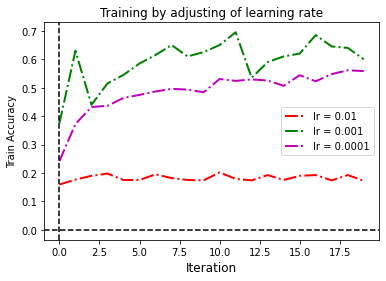

In [37]:
import matplotlib.pyplot as plt
import numpy as np

t_acc1 = torch.tensor(t_acc1, device = 'cpu')
t_acc2 = torch.tensor(t_acc2, device = 'cpu')
t_acc3 = torch.tensor(t_acc3, device = 'cpu')

plt.plot(t_acc1, color ='r', linestyle = '-.', linewidth=2, label='lr = 0.01')
plt.plot(t_acc2, color ='g', linestyle = '-.', linewidth=2, label='lr = 0.001')
plt.plot(t_acc3, color ='m', linestyle = '-.', linewidth=2, label='lr = 0.0001')
#plt.plot(ylist, color ='blue', linestyle = '--')
plt.axvline(0, color='k', linestyle='--')# draw the axis y 
plt.axhline(0, color='k', linestyle='--')# draw the axis x
plt.title("Training by adjusting of learning rate")# name the diagram
plt.xlabel("Iteration", fontsize=12)# name the axis x
plt.ylabel("Train Accuracy")# name the axis y
plt.legend()
plt.show()# show the diagram

C:\Users\BiXY\AppData\Local\Temp\ipykernel_18828\1527390791.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_acc2 = torch.tensor(t_acc2, device = 'cpu')
C:\Users\BiXY\AppData\Local\Temp\ipykernel_18828\1527390791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_acc4 = torch.tensor(t_acc4, device = 'cpu')
C:\Users\BiXY\AppData\Local\Temp\ipykernel_18828\1527390791.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_acc5 = torch.tensor(t_acc5, device = 'cpu')


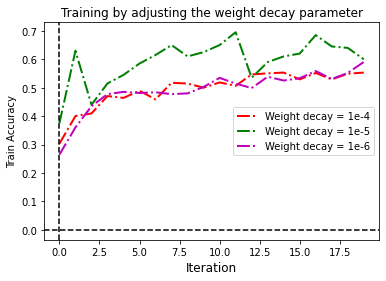

In [38]:
import matplotlib.pyplot as plt
import numpy as np

t_acc2 = torch.tensor(t_acc2, device = 'cpu')
t_acc4 = torch.tensor(t_acc4, device = 'cpu')
t_acc5 = torch.tensor(t_acc5, device = 'cpu')

plt.plot(t_acc4, color ='r', linestyle = '-.', linewidth=2, label='Weight decay = 1e-4')
plt.plot(t_acc2, color ='g', linestyle = '-.', linewidth=2, label='Weight decay = 1e-5')
plt.plot(t_acc5, color ='m', linestyle = '-.', linewidth=2, label='Weight decay = 1e-6')
#plt.plot(ylist, color ='blue', linestyle = '--')
plt.axvline(0, color='k', linestyle='--')# draw the axis y 
plt.axhline(0, color='k', linestyle='--')# draw the axis x
plt.title("Training by adjusting of learning rate")# name the diagram
plt.xlabel("Iteration", fontsize=12)# name the axis x
plt.ylabel("Train Accuracy")# name the axis y
plt.legend()
plt.show()# show the diagram

C:\Users\BiXY\AppData\Local\Temp\ipykernel_18828\1089787741.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_acc1 = torch.tensor(v_acc1, device = 'cpu')
C:\Users\BiXY\AppData\Local\Temp\ipykernel_18828\1089787741.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_acc2 = torch.tensor(v_acc2, device = 'cpu')
C:\Users\BiXY\AppData\Local\Temp\ipykernel_18828\1089787741.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_acc3 = torch.tensor(v_acc3, device = 'cpu')


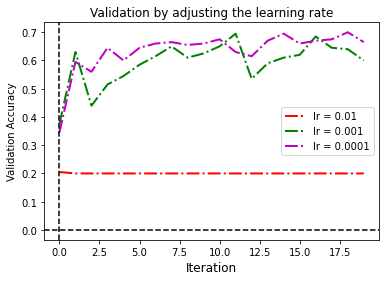

In [39]:
import matplotlib.pyplot as plt
import numpy as np

v_acc1 = torch.tensor(v_acc1, device = 'cpu')
v_acc2 = torch.tensor(v_acc2, device = 'cpu')
v_acc3 = torch.tensor(v_acc3, device = 'cpu')

plt.plot(v_acc1, color ='r', linestyle = '-.', linewidth=2, label='lr = 0.01')
plt.plot(v_acc2, color ='g', linestyle = '-.', linewidth=2, label='lr = 0.001')
plt.plot(v_acc3, color ='m', linestyle = '-.', linewidth=2, label='lr = 0.0001')

#plt.plot(ylist, color ='blue', linestyle = '--')
plt.axvline(0, color='k', linestyle='--')# draw the axis y 
plt.axhline(0, color='k', linestyle='--')# draw the axis x
plt.title("Training by adjusting of learning rate")# name the diagram
plt.xlabel("Iteration", fontsize=12)# name the axis x
plt.ylabel("Train Accuracy")# name the axis y
plt.legend()
plt.show()# show the diagram

C:\Users\BiXY\AppData\Local\Temp\ipykernel_18828\2788517580.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_acc2 = torch.tensor(v_acc2, device = 'cpu')
C:\Users\BiXY\AppData\Local\Temp\ipykernel_18828\2788517580.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_acc4 = torch.tensor(v_acc4, device = 'cpu')
C:\Users\BiXY\AppData\Local\Temp\ipykernel_18828\2788517580.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_acc5 = torch.tensor(v_acc5, device = 'cpu')


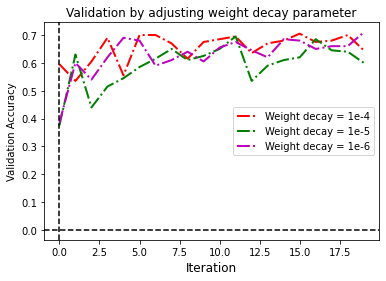

In [40]:
import matplotlib.pyplot as plt
import numpy as np

v_acc2 = torch.tensor(v_acc2, device = 'cpu')
v_acc4 = torch.tensor(v_acc4, device = 'cpu')
v_acc5 = torch.tensor(v_acc5, device = 'cpu')

plt.plot(v_acc4, color ='r', linestyle = '-.', linewidth=2, label='Weight decay = 1e-4')
plt.plot(v_acc2, color ='g', linestyle = '-.', linewidth=2, label='Weight decay = 1e-5')
plt.plot(v_acc5, color ='m', linestyle = '-.', linewidth=2, label='Weight decay = 1e-6')

#plt.plot(ylist, color ='blue', linestyle = '--')
plt.axvline(0, color='k', linestyle='--')# draw the axis y 
plt.axhline(0, color='k', linestyle='--')# draw the axis x
plt.title("Training by adjusting of learning rate")# name the diagram
plt.xlabel("Iteration", fontsize=12)# name the axis x
plt.ylabel("Train Accuracy")# name the axis y
plt.legend()
plt.show()# show the diagram

C:\Users\BiXY\AppData\Local\Temp\ipykernel_18828\2921109366.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_acc2 = torch.tensor(t_acc2, device = 'cpu')
C:\Users\BiXY\AppData\Local\Temp\ipykernel_18828\2921109366.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_acc6 = torch.tensor(t_acc6, device = 'cpu')


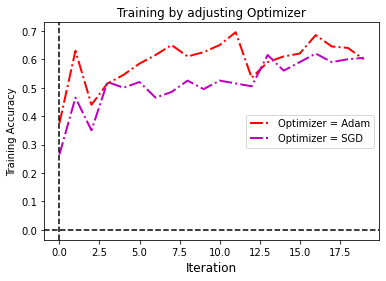

In [43]:
import matplotlib.pyplot as plt
import numpy as np


t_acc2 = torch.tensor(t_acc2, device = 'cpu')
t_acc6 = torch.tensor(t_acc6, device = 'cpu')

plt.plot(t_acc2, color ='r', linestyle = '-.', linewidth=2, label='Optimizer = Adam')
plt.plot(t_acc6, color ='m', linestyle = '-.', linewidth=2, label='Optimizer = SGD')


#plt.plot(ylist, color ='blue', linestyle = '--')
plt.axvline(0, color='k', linestyle='--')# draw the axis y 
plt.axhline(0, color='k', linestyle='--')# draw the axis x
plt.title("Training by adjusting of learning rate")# name the diagram
plt.xlabel("Iteration", fontsize=12)# name the axis x
plt.ylabel("Train Accuracy")# name the axis y
plt.legend()
plt.show()# show the diagram

C:\Users\BiXY\AppData\Local\Temp\ipykernel_18828\1080752149.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_acc2 = torch.tensor(v_acc2, device = 'cpu')
C:\Users\BiXY\AppData\Local\Temp\ipykernel_18828\1080752149.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_acc6 = torch.tensor(v_acc6, device = 'cpu')


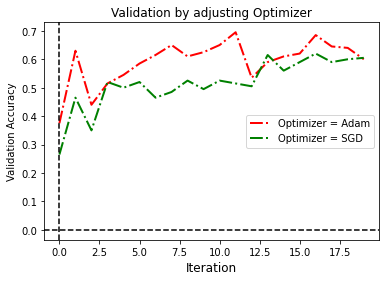

In [42]:
import matplotlib.pyplot as plt
import numpy as np


v_acc2 = torch.tensor(v_acc2, device = 'cpu')
v_acc6 = torch.tensor(v_acc6, device = 'cpu')

plt.plot(v_acc2, color ='r', linestyle = '-.', linewidth=2, label='Optimizer = Adam')
plt.plot(v_acc6, color ='g', linestyle = '-.', linewidth=2, label='Optimizer = SGD')


#plt.plot(ylist, color ='blue', linestyle = '--')
plt.axvline(0, color='k', linestyle='--')# draw the axis y 
plt.axhline(0, color='k', linestyle='--')# draw the axis x
plt.title("Training by adjusting of learning rate")# name the diagram
plt.xlabel("Iteration", fontsize=12)# name the axis x
plt.ylabel("Train Accuracy")# name the axis y
plt.legend()
plt.show()# show the diagram